# ロジスティック回帰他

### 今回利用するデータ

今回の演習では、Titanicの生存者情報データを用いる.
データは`titanic`パッケージに入っている`titanic_train`を用いる.

まずは, 変数を確認する

In [ ]:
library(pacman)
p_load(titanic)
names(titanic_train)

 [1] "PassengerId" "Survived"    "Pclass"      "Name"        "Sex"        
 [6] "Age"         "SibSp"       "Parch"       "Ticket"      "Fare"       
[11] "Cabin"       "Embarked"   

# data transformation

## 欠測値の処理

### 欠測値の定義

今回使うデータは空欄と`NA`が混在しているため, NAに統一する.
利用するのは`naniar::replace_with_na_all()`関数.

In [ ]:
p_load(naniar)
train <- replace_with_na_all(titanic_train,
                             condition = ~.x %in% c("NA", ""))

### データ構造の確認

データ構造を確認するため, `dplyr::glimpse()`関数を利用する.

In [ ]:
p_load(dplyr)
glimpse(train)

Rows: 891
Columns: 12
$ PassengerId <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,…
$ Survived    <int> 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1…
$ Pclass      <int> 3, 1, 3, 1, 3, 3, 1, 3, 3, 2, 3, 1, 3, 3, 3, 2, 3, 2, 3, 3…
$ Name        <chr> "Braund, Mr. Owen Harris", "Cumings, Mrs. John Bradley (Fl…
$ Sex         <chr> "male", "female", "female", "female", "male", "male", "mal…
$ Age         <dbl> 22, 38, 26, 35, 35, NA, 54, 2, 27, 14, 4, 58, 20, 39, 14, …
$ SibSp       <int> 1, 1, 0, 1, 0, 0, 0, 3, 0, 1, 1, 0, 0, 1, 0, 0, 4, 0, 1, 0…
$ Parch       <int> 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 0, 5, 0, 0, 1, 0, 0, 0…
$ Ticket      <chr> "A/5 21171", "PC 17599", "STON/O2. 3101282", "113803", "37…
$ Fare        <dbl> 7.2500, 71.2833, 7.9250, 53.1000, 8.0500, 8.4583, 51.8625,…
$ Cabin       <chr> NA, "C85", NA, "C123", NA, NA, "E46", NA, NA, NA, "G6", "C…
$ Embarked    <chr> "S", "C", "S", "S", "S", "Q", "S", "S", "S", "C", "S", "S"…

## 先頭から数行を確認

先頭から数行を確認するために`head()`関数を利用する.
`Cabin`の1行目と3行目は欠測値になっていることがわかる.

In [ ]:
head(train)

# A tibble: 6 × 12
  PassengerId Survived Pclass Name    Sex     Age SibSp Parch Ticket  Fare Cabin
        <int>    <int>  <int> <chr>   <chr> <dbl> <int> <int> <chr>  <dbl> <chr>
1           1        0      3 Braund… male     22     1     0 A/5 2…  7.25 <NA> 
2           2        1      1 Cuming… fema…    38     1     0 PC 17… 71.3  C85  
3           3        1      3 Heikki… fema…    26     0     0 STON/…  7.92 <NA> 
4           4        1      1 Futrel… fema…    35     1     0 113803 53.1  C123 
5           5        0      3 Allen,… male     35     0     0 373450  8.05 <NA> 
6           6        0      3 Moran,… male     NA     0     0 330877  8.46 <NA> 
# ℹ 1 more variable: Embarked <chr>

### データの概要を確認

データの記述統計を確認するために`summary()`関数を利用する.
文字列の欠測値は表示されない.

In [ ]:
summary(train)

  PassengerId       Survived          Pclass          Name          
 Min.   :  1.0   Min.   :0.0000   Min.   :1.000   Length:891        
 1st Qu.:223.5   1st Qu.:0.0000   1st Qu.:2.000   Class :character  
 Median :446.0   Median :0.0000   Median :3.000   Mode  :character  
 Mean   :446.0   Mean   :0.3838   Mean   :2.309                     
 3rd Qu.:668.5   3rd Qu.:1.0000   3rd Qu.:3.000                     
 Max.   :891.0   Max.   :1.0000   Max.   :3.000                     
                                                                    
     Sex                 Age            SibSp           Parch       
 Length:891         Min.   : 0.42   Min.   :0.000   Min.   :0.0000  
 Class :character   1st Qu.:20.12   1st Qu.:0.000   1st Qu.:0.0000  
 Mode  :character   Median :28.00   Median :0.000   Median :0.0000  
                    Mean   :29.70   Mean   :0.523   Mean   :0.3816  
                    3rd Qu.:38.00   3rd Qu.:1.000   3rd Qu.:0.0000  
                    Max.   :80.00 

### 欠測値を確認

このデータはいくつかの欠測値を含んでいるため,
欠測値がどの変数にいくつ含まれているのか確認する.
`dplyr::summarise()`関数を利用し,
`is.na`でNAに該当するセルがいくつあるのかを数え上げる.

In [ ]:
summarise(train,
          across(everything(),
                 \(x) sum(is.na(x))))

# A tibble: 1 × 12
  PassengerId Survived Pclass  Name   Sex   Age SibSp Parch Ticket  Fare Cabin
        <int>    <int>  <int> <int> <int> <int> <int> <int>  <int> <int> <int>
1           0        0      0     0     0   177     0     0      0     0   687
# ℹ 1 more variable: Embarked <int>

### 欠測値の除去

欠測値を含む行を削除する. これをリストワイズ除去という. ここでは,
`na.omit()`関数と`tidyr::drop_na()`関数の2種類を紹介する.

In [ ]:
train2 <- na.omit(train)

p_load(tidyr)
train2 <- tidyr::drop_na(train)

### 欠測値を除去したデータを確認

In [ ]:
head(train2)

# A tibble: 6 × 12
  PassengerId Survived Pclass Name    Sex     Age SibSp Parch Ticket  Fare Cabin
        <int>    <int>  <int> <chr>   <chr> <dbl> <int> <int> <chr>  <dbl> <chr>
1           2        1      1 Cuming… fema…    38     1     0 PC 17…  71.3 C85  
2           4        1      1 Futrel… fema…    35     1     0 113803  53.1 C123 
3           7        0      1 McCart… male     54     0     0 17463   51.9 E46  
4          11        1      3 Sandst… fema…     4     1     1 PP 95…  16.7 G6   
5          12        1      1 Bonnel… fema…    58     0     0 113783  26.6 C103 
6          22        1      2 Beesle… male     34     0     0 248698  13   D56  
# ℹ 1 more variable: Embarked <chr>

In [ ]:
summary(train2)

  PassengerId       Survived          Pclass          Name          
 Min.   :  2.0   Min.   :0.0000   Min.   :1.000   Length:183        
 1st Qu.:263.5   1st Qu.:0.0000   1st Qu.:1.000   Class :character  
 Median :457.0   Median :1.0000   Median :1.000   Mode  :character  
 Mean   :455.4   Mean   :0.6721   Mean   :1.191                     
 3rd Qu.:676.0   3rd Qu.:1.0000   3rd Qu.:1.000                     
 Max.   :890.0   Max.   :1.0000   Max.   :3.000                     
     Sex                 Age            SibSp            Parch       
 Length:183         Min.   : 0.92   Min.   :0.0000   Min.   :0.0000  
 Class :character   1st Qu.:24.00   1st Qu.:0.0000   1st Qu.:0.0000  
 Mode  :character   Median :36.00   Median :0.0000   Median :0.0000  
                    Mean   :35.67   Mean   :0.4645   Mean   :0.4754  
                    3rd Qu.:47.50   3rd Qu.:1.0000   3rd Qu.:1.0000  
                    Max.   :80.00   Max.   :3.0000   Max.   :4.0000  
    Ticket               Fa

## パイプ演算子

### コードを書いていて困ること1

`()`がいくつも重なるととてもコードが読みにくい.
`()`の一番内側から処理を実行し,
コードの先頭にある関数は一番最後に実行する関数となる. 例えば,
下の例にあるコードを実行する場合, `fun3(x)`を最初に実行し,
その結果に対して`fun2()`を実行し,
さらにその結果を`fun1()`が受け取って実行する.
これは人間の思考と逆である.

In [ ]:
# fun1(fun2(fun3(x)))

### コードを書いていて困ること2

関数などをネストして書くことを避けると一時的に作成した中間的なオブジェクトが多くなる.
全くだめなわけではないが, 多すぎると見通しが悪い.

In [ ]:
# x1 <- fun3(x)
# x2 <- fun2(x1)
# fun1(x2)

$\rightarrow$ これらの解決する手段として`|>`(パイプ)演算子がある

### `|>`(パイプ)とは

`|>`(パイプ)演算子を使うことで、パイプ演算子の前の結果をパイプ演算子の後の関数の第一引数に入れることができる.
パイプ演算子はR4.1.0から素のRに導入された.

以前のパイプ演算子`%>%`は`magrittr`パッケージの中の関数の1つ.
`dplyr`パッケージを読み込むと一緒に読み込んでくれる.

`|>`はctrl(cmd) + Shift(opt) + Mで書くことができる.
特に`dplyr`パッケージ等を用いたデータの前処理で大活躍する.

In [ ]:
# fun3(x) |> 
#   fun2() |> 
#   fun1()

## データの整形

### 変数の変換

いくつかの変数のデータ型を`Integer`や`Character`から`factor`に,
`Character`から文字の抜き出しなどを行う.
列の変換には`dplyr::mutate()`関数を利用する

In [ ]:
p_load(stringr)
train3 <- train2 |> 
  mutate(across(c(Survived, Pclass, Sex, Embarked),
                as.factor)) |> 
  mutate(CabinLetter = str_sub(Cabin,
                               start = 1,
                               end   = 1) |> 
           as.factor()) |> 
  mutate(Title = str_sub(Name,
                         start = str_locate(Name, ",")[,1] + 2,
                         end   = str_locate(Name, "\\.")[,1] - 1) |> 
           as.factor())

# Logistic Regression Model

### ロジスティック回帰モデル

ロジスティック回帰モデルを推定するために`glm(family = binomial(link="logit"))`を利用する.
モデルを2つ作成し, 推定を行う.

In [ ]:
model1 <- Survived ~ Pclass + Sex + Age + 
  SibSp + Parch + Fare + Embarked +
  CabinLetter + Title
model2 <- Survived ~ Pclass + Sex + Age

### モデル1の結果

`jtools::summ()`関数を利用して結果の確認を行う.

In [ ]:
glm_logit1 <- glm(model1, 
                  data   = train3, 
                  family = binomial(link = 'logit'))
p_load(jtools)
summ(glm_logit1)

MODEL INFO:
Observations: 183
Dependent Variable: Survived
Type: Generalized linear model
  Family: binomial 
  Link function: logit 

MODEL FIT:
χ²(28) = 98.56, p = 0.00
Pseudo-R² (Cragg-Uhler) = 0.58
Pseudo-R² (McFadden) = 0.43
AIC = 190.99, BIC = 284.07 

Standard errors:MLE
-----------------------------------------------------------
                            Est.       S.E.   z val.      p
----------------------- -------- ---------- -------- ------
(Intercept)                 2.04    9224.40     0.00   1.00
Pclass2                    -0.67       1.26    -0.53   0.59
Pclass3                    -0.18       1.58    -0.11   0.91
Sexmale                   -17.81    6522.64    -0.00   1.00
Age                        -0.03       0.02    -1.57   0.12
SibSp                       0.30       0.42     0.71   0.48
Parch                      -0.57       0.41    -1.40   0.16
Fare                        0.00       0.00     1.00   0.32
EmbarkedQ                  -2.06       2.11    -0.98   0.33
E

### 多重共線性のチェック

`summ()`関数の引数`vifs`を利用してモデル1の多重共線性をチェックする.
`Sex`と`Title`の値が大きく, 推定に問題があることが示唆される. `Sex`とMr,
Mrsなどを含む`Title`が相関するのは当然.

In [ ]:
summ(glm_logit1, vifs = TRUE)

MODEL INFO:
Observations: 183
Dependent Variable: Survived
Type: Generalized linear model
  Family: binomial 
  Link function: logit 

MODEL FIT:
χ²(28) = 98.56, p = 0.00
Pseudo-R² (Cragg-Uhler) = 0.58
Pseudo-R² (McFadden) = 0.43
AIC = 190.99, BIC = 284.07 

Standard errors:MLE
--------------------------------------------------------------------------
                            Est.       S.E.   z val.      p            VIF
----------------------- -------- ---------- -------- ------ --------------
(Intercept)                 2.04    9224.40     0.00   1.00               
Pclass2                    -0.67       1.26    -0.53   0.59           5.67
Pclass3                    -0.18       1.58    -0.11   0.91           5.67
Sexmale                   -17.81    6522.64    -0.00   1.00   153309194.86
Age                        -0.03       0.02    -1.57   0.12           1.43
SibSp                       0.30       0.42     0.71   0.48           1.35
Parch                      -0.57       0.41   

### モデル2の結果

モデルを変えて(`CabinLetter`と`Title`を除いて)分析を行う.

In [ ]:
glm_logit2 <- glm(model2,
                  data   = train3, 
                  family = binomial(link = 'logit'))
summ(glm_logit2,
     vifs = TRUE)

MODEL INFO:
Observations: 183
Dependent Variable: Survived
Type: Generalized linear model
  Family: binomial 
  Link function: logit 

MODEL FIT:
χ²(4) = 68.35, p = 0.00
Pseudo-R² (Cragg-Uhler) = 0.43
Pseudo-R² (McFadden) = 0.30
AIC = 173.21, BIC = 189.25 

Standard errors:MLE
-------------------------------------------------------
                     Est.   S.E.   z val.      p    VIF
----------------- ------- ------ -------- ------ ------
(Intercept)          4.08   0.72     5.68   0.00       
Pclass2             -0.13   0.80    -0.16   0.87   1.20
Pclass3             -1.88   0.91    -2.06   0.04   1.20
Sexmale             -2.87   0.49    -5.86   0.00   1.04
Age                 -0.04   0.01    -2.68   0.01   1.15
-------------------------------------------------------

### 推定された係数の図示

推定された係数を図で確認するために,
`coefplot::coefplot()`関数を利用する.

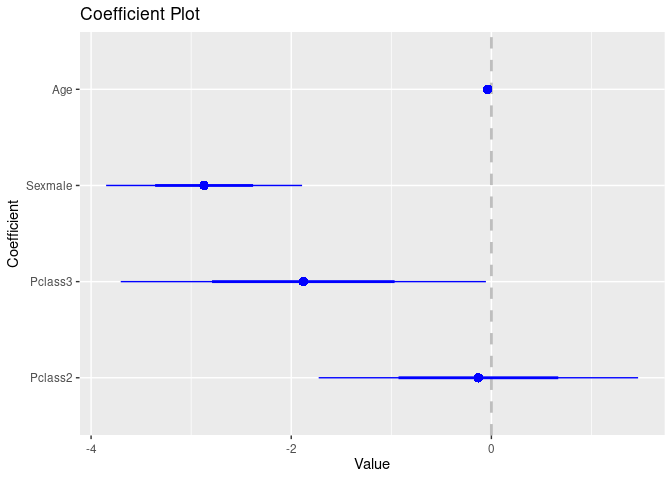

In [ ]:
p_load(coefplot)
coefplot(glm_logit2, 
         intercept = FALSE)

### オッズ比の算出

ロジスティック回帰モデルにより算出された回帰係数はそのままでは解釈できないため,
指数変換しオッズ比を計算する.

In [ ]:
summ(glm_logit2, exp = TRUE)

MODEL INFO:
Observations: 183
Dependent Variable: Survived
Type: Generalized linear model
  Family: binomial 
  Link function: logit 

MODEL FIT:
χ²(4) = 68.35, p = 0.00
Pseudo-R² (Cragg-Uhler) = 0.43
Pseudo-R² (McFadden) = 0.30
AIC = 173.21, BIC = 189.25 

Standard errors:MLE
--------------------------------------------------------------
                    exp(Est.)    2.5%    97.5%   z val.      p
----------------- ----------- ------- -------- -------- ------
(Intercept)             59.22   14.48   242.24     5.68   0.00
Pclass2                  0.88    0.18     4.20    -0.16   0.87
Pclass3                  0.15    0.03     0.91    -2.06   0.04
Sexmale                  0.06    0.02     0.15    -5.86   0.00
Age                      0.96    0.94     0.99    -2.68   0.01
--------------------------------------------------------------

# オッズ比の理解

指数変換して計算したオッズ比がどのようなものかを理解する.

In [ ]:
p <- predict(glm_logit2,
        newdata = tibble(Pclass = factor(1),
                         Sex    = "male",
                         Age    = 35),
        type    = "response")
q <- predict(glm_logit2,
        newdata = tibble(Pclass = factor(2),
                         Sex    = "male",
                         Age    = 35),
        type    = "response")
(q / (1 - q)) / (p / (1 - p))

        1 
0.8781548 

### オッズ比の図示

`ggplot2`を使ってオッズ比の信頼区間を図示する.

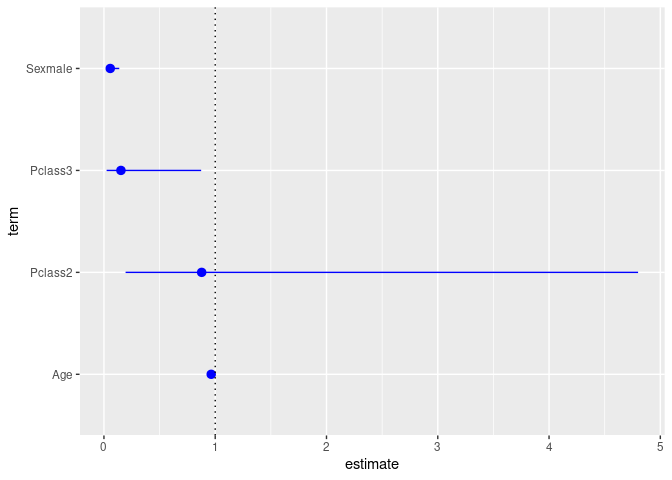

In [ ]:
p_load(broom)
broom::tidy(glm_logit2, 
            conf.int     = TRUE, 
            exponentiate = TRUE) |> 
  select(term, 
         estimate,
         conf.low, 
         conf.high) |> 
  filter(term != "(Intercept)") |> 
  ggplot() +
  aes(x    = term,
      y    = estimate,
      ymin = conf.low,
      ymax = conf.high) +
  geom_pointrange(size   = .5,
                  colour = "blue") +
  geom_hline(yintercept = 1,
             linetype   = 'dotted') +
  coord_flip()

### ロジスティック回帰モデルの残差チェック

残差をチェックするために`autoplot`を行う.

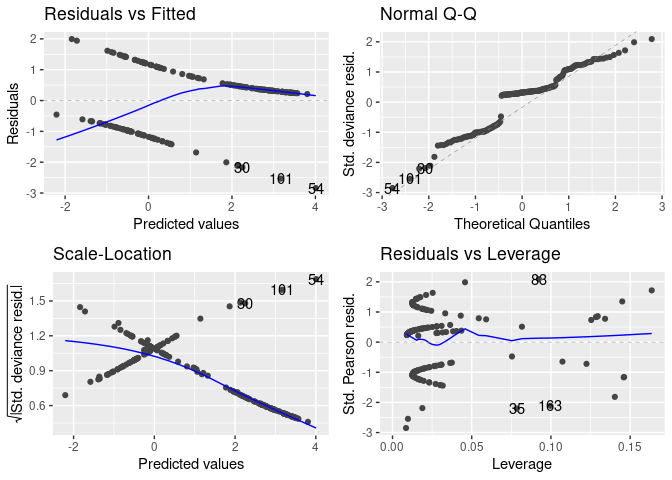

In [ ]:
p_load(ggfortify)
autoplot(glm_logit2)

### 評価用の関数作成

In [ ]:
perform <- function(data, observed, predict){
  library(dplyr)
  obs  <- enquo(observed)
  pred <- enquo(predict)
  result <- data |> 
    select(obs := !!obs, pred := !!pred) |> 
    mutate(TP = obs == 1 & pred == 1,
           FP = obs == 0 & pred == 1,
           TN = obs == 0 & pred == 0,
           FN = obs == 1 & pred == 0) |> 
    summarise(across(c(TP, FP, TN, FN), sum)) |> 
    mutate(Pe = ((TP + FN) * (TP + FP) + (TN + FN) * (TN + FP)) /
             sum(TP, FP, TN, FN)^2) |> 
    transmute(Accuracy  = (TP + TN) / (TP + TN + FP + FN),
              Precision = TP / (TP + FP),
              Recall    = TP / (TP + FN),
              F1        = 2 * Precision * Recall / (Precision + Recall),
              kappa     = (Accuracy - Pe) / (1 - Pe))
  return(result)
}

### ロジスティックモデルを用いた予測と的中率

`predict`を用いてモデル上の(理論的な)生存確率を予測する.
予測された結果が0.5より大きい場合は生存, 0.5以下であれば死亡とする.
利用したデータを用いた予測の結果, 76.5%が的中した.

In [ ]:
train3 |>
  mutate(predict = predict(glm_logit2, 
                           type = "response")) |> 
  mutate(survive = predict > 0.5) |> 
  perform(Survived, survive)

# A tibble: 1 × 5
  Accuracy Precision Recall    F1 kappa
     <dbl>     <dbl>  <dbl> <dbl> <dbl>
1    0.765     0.839  0.805 0.822 0.478

### LOOCVによる評価

`caret`パッケージを利用してLOOCVによるモデルの評価を行う. 正解率は75.4%.

In [ ]:
p_load(caret)
train(data      = train3,
      model2,
      method    = "glm",
      family    = binomial(link = "logit"),
      metric    = "Accuracy",
      trControl = trainControl(method = "LOOCV"))

Generalized Linear Model 

183 samples
  3 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Leave-One-Out Cross-Validation 
Summary of sample sizes: 182, 182, 182, 182, 182, 182, ... 
Resampling results:

  Accuracy   Kappa   
  0.7540984  0.449127

# Probit Regression Model

### プロビット回帰モデル

プロビット回帰モデルを推定するためには,
`glm(family=binomial(link='probit'))`を指定する.

In [ ]:
glm_probit <- glm(model2, 
                  data   = train3,
                  family = binomial(link = 'probit'))
summ(glm_probit)

MODEL INFO:
Observations: 183
Dependent Variable: Survived
Type: Generalized linear model
  Family: binomial 
  Link function: probit 

MODEL FIT:
χ²(4) = 67.64, p = 0.00
Pseudo-R² (Cragg-Uhler) = 0.43
Pseudo-R² (McFadden) = 0.29
AIC = 173.91, BIC = 189.96 

Standard errors:MLE
------------------------------------------------
                     Est.   S.E.   z val.      p
----------------- ------- ------ -------- ------
(Intercept)          2.25   0.38     5.99   0.00
Pclass2             -0.03   0.45    -0.06   0.95
Pclass3             -1.05   0.50    -2.09   0.04
Sexmale             -1.63   0.25    -6.50   0.00
Age                 -0.02   0.01    -2.50   0.01
------------------------------------------------

### プロビットモデルで推定された係数の図示

推定された係数を図で確認するために, `coefplot::coefplot`を利用する.

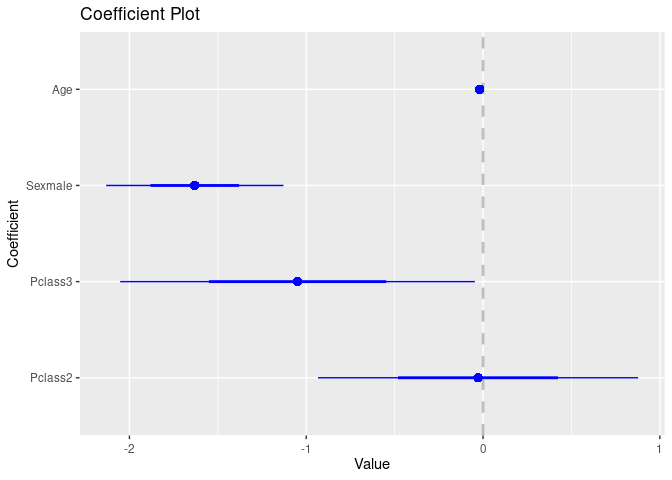

In [ ]:
coefplot(glm_probit, intercept = FALSE)

### プロビットモデルの残差チェック

残差をチェックするために`autoplot`を行う.

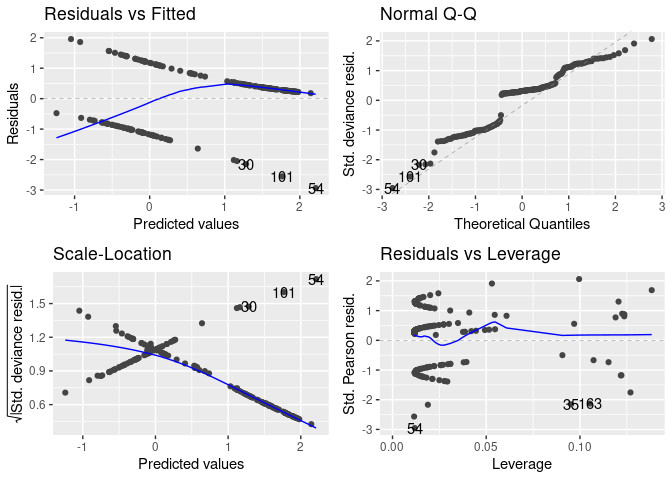

In [ ]:
autoplot(glm_probit)

### プロビットモデルを用いた予測と的中率

`predict`を用いてモデル上の(理論的な)生存確率を予測する.
予測された結果が0.5より大きい場合は生存, 0.5以下であれば死亡とする.
利用したデータを用いた予測の結果, 77.0%が的中した.

In [ ]:
train3 |>
  mutate(predict = predict(glm_probit, 
                           type = "response")) |> 
  mutate(survive = predict > 0.5) |> 
  perform(Survived, survive)

# A tibble: 1 × 5
  Accuracy Precision Recall    F1 kappa
     <dbl>     <dbl>  <dbl> <dbl> <dbl>
1    0.770     0.846  0.805 0.825 0.492

### LOOCVによる評価

`caret`パッケージを利用してLOOCVによるモデルの評価を行う. 正解率は75.4%.

In [ ]:
train(data      = train3,
      model2,
      method    = "glm",
      family    = binomial(link = "probit"),
      metric    = "Accuracy",
      trControl = trainControl(method = "LOOCV"))

Generalized Linear Model 

183 samples
  3 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Leave-One-Out Cross-Validation 
Summary of sample sizes: 182, 182, 182, 182, 182, 182, ... 
Resampling results:

  Accuracy   Kappa    
  0.7540984  0.4537313

# Complementary Log-Log regression model

### 補対数対数回帰モデル

補対数対数回帰モデルを推定するためには,
`glm(family=binomial(link='cloglog'))`を指定する.

In [ ]:
glm_cloglog <- glm(model2, 
                   data   = train3,
                   family = binomial(link = 'cloglog'))
summ(glm_cloglog)

MODEL INFO:
Observations: 183
Dependent Variable: Survived
Type: Generalized linear model
  Family: binomial 
  Link function: cloglog 

MODEL FIT:
χ²(4) = 66.30, p = 0.00
Pseudo-R² (Cragg-Uhler) = 0.42
Pseudo-R² (McFadden) = 0.29
AIC = 175.25, BIC = 191.30 

Standard errors:MLE
------------------------------------------------
                     Est.   S.E.   z val.      p
----------------- ------- ------ -------- ------
(Intercept)          1.57   0.33     4.75   0.00
Pclass2              0.03   0.41     0.08   0.94
Pclass3             -1.10   0.53    -2.09   0.04
Sexmale             -1.52   0.22    -6.86   0.00
Age                 -0.01   0.01    -1.94   0.05
------------------------------------------------

### 補対数対数モデルで推定された係数の図示

推定された係数を図で確認するために, `coefplot::coefplot`を利用する.

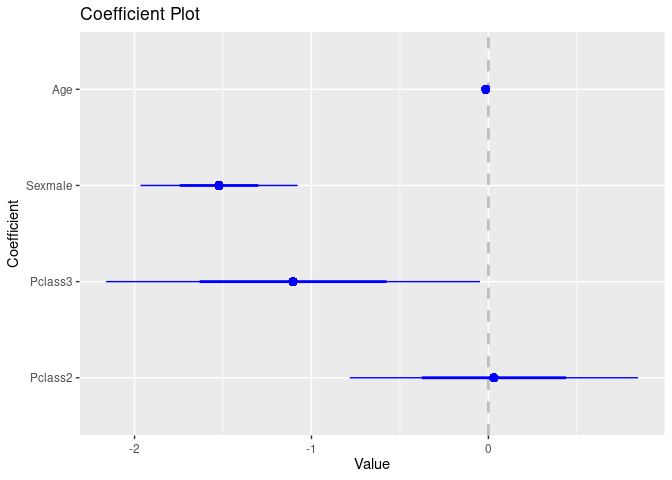

In [ ]:
coefplot(glm_cloglog, intercept = FALSE)

### 補対数対数モデルの残差チェック

残差をチェックするために`autoplot`を行う.

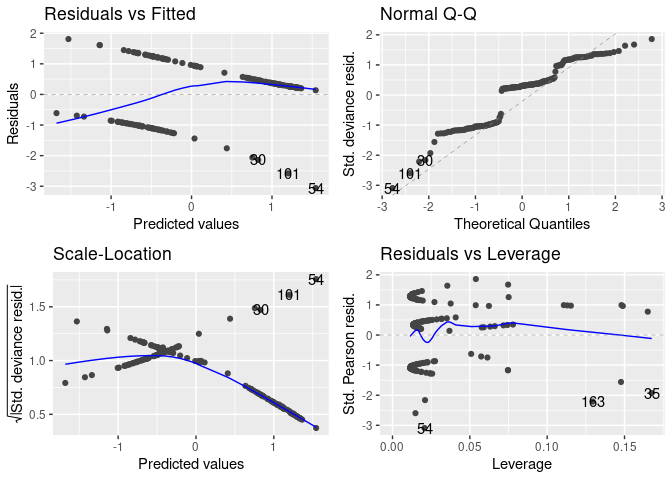

In [ ]:
autoplot(glm_cloglog)

### 補対数対数モデルを用いた予測と的中率

`predict`を用いてモデル上の(理論的な)生存確率を予測する.
予測された結果が0.5より大きい場合は生存, 0.5以下であれば死亡とする.
利用したデータを用いた予測の結果, 77.6%が的中した.

In [ ]:
train3 |>
  mutate(predict = predict(glm_cloglog, 
                           type = "response")) |> 
  mutate(survive = predict > 0.5) |> 
  perform(Survived, survive)

# A tibble: 1 × 5
  Accuracy Precision Recall    F1 kappa
     <dbl>     <dbl>  <dbl> <dbl> <dbl>
1    0.776     0.880  0.772 0.823 0.522

### LOOCVによる評価

`caret`パッケージを利用してLOOCVによるモデルの評価を行う. 正解率は74.3%.

In [ ]:
train(data      = train3,
      model2,
      method    = "glm",
      family    = binomial(link = "cloglog"),
      metric    = "Accuracy",
      trControl = trainControl(method = "LOOCV"))

Generalized Linear Model 

183 samples
  3 predictor
  2 classes: '0', '1' 

No pre-processing
Resampling: Leave-One-Out Cross-Validation 
Summary of sample sizes: 182, 182, 182, 182, 182, 182, ... 
Resampling results:

  Accuracy   Kappa    
  0.7431694  0.4479106

# Appendix

### テストデータによる予測

トレーニングデータで作成したモデルから, テストデータで予測する.

In [ ]:
test <- titanic_test |> 
  replace_with_na_all(condition = ~.x %in% c("NA", "")) |> 
  tidyr::drop_na() |> 
  mutate_at(vars(Pclass, Sex, Embarked), as.factor) |> 
  broom::augment(x            = glm_logit2,
                 newdata      = _,
                 type.predict = "response") |> 
  mutate(survive = .fitted > 0.5)

### 多重代入法による欠測値の処理

欠測値をバイアスをより少なく扱うためには, 多重代入法などを利用する.
`mice`, `norm2`, `miceadds`パッケージを利用する.

In [ ]:
p_load(mice, norm2, miceadds)

Installing package into '/cloud/lib/x86_64-pc-linux-gnu-library/4.4'
(as 'lib' is unspecified)

also installing the dependencies 'ucminf', 'ordinal', 'pan', 'jomo', 'haven', 'glmnet', 'mitml'


mice installed

Installing package into '/cloud/lib/x86_64-pc-linux-gnu-library/4.4'
(as 'lib' is unspecified)


A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages


Please use `install.packages('BiocManager')` and then retry.

Warning in p_install(package, character.only = TRUE, ...):

Warning in library(package, lib.loc = lib.loc, character.only = TRUE,
logical.return = TRUE, : there is no package called 'norm2'

Installing package into '/cloud/lib/x86_64-pc-linux-gnu-library/4.4'
(as 'lib' is unspecified)

also installing the dependencies 'DBI', 'mitools', 'RcppArmadillo'


miceadds installed

Warning in p_load(mice, norm2, miceadds): Failed to install/load:
norm2

Warning in glm.mids(model2, data =
mice(select(mutate(replace_with_na_all(train, : Use with(imp, glm(yourmodel).


 iter imp variable
  1   1  Age  Embarked
  1   2  Age  Embarked
  1   3  Age  Embarked
  1   4  Age  Embarked
  1   5  Age  Embarked
  1   6  Age  Embarked
  1   7  Age  Embarked
  1   8  Age  Embarked
  1   9  Age  Embarked
  1   10  Age  Embarked
  1   11  Age  Embarked
  1   12  Age  Embarked
  1   13  Age  Embarked
  1   14  Age  Embarked
  1   15  Age  Embarked
  1   16  Age  Embarked
  1   17  Age  Embarked
  1   18  Age  Embarked
  1   19  Age  Embarked
  1   20  Age  Embarked
  1   21  Age  Embarked
  1   22  Age  Embarked
  1   23  Age  Embarked
  1   24  Age  Embarked
  1   25  Age  Embarked
  1   26  Age  Embarked
  1   27  Age  Embarked
  1   28  Age  Embarked
  1   29  Age  Embarked
  1   30  Age  Embarked
  1   31  Age  Embarked
  1   32  Age  Embarked
  1   33  Age  Embarked
  1   34  Age  Embarked
  1   35  Age  Embarked
  1   36  Age  Embarked
  1   37  Age  Embarked
  1   38  Age  Embarked
  1   39  Age  Embarked
  1   40  Age  Embarked
  1   41  Age  Embarked
  1  

### 多重代入法による結果の確認

多重代入法の結果をpoolした上で確認する.

In [ ]:
glm_logit_imp |> 
  pool() |> 
  summary()

         term    estimate   std.error  statistic       df      p.value
1 (Intercept)  3.53902344 0.375889219   9.415070 709.4391 6.471257e-20
2     Pclass2 -1.16841638 0.263008360  -4.442507 857.9440 1.005501e-05
3     Pclass3 -2.42909763 0.256826989  -9.458109 813.9947 3.265504e-20
4     Sexmale -2.58592457 0.187618050 -13.782920 878.5296 2.867690e-39
5         Age -0.03192595 0.007331264  -4.354768 595.1110 1.568431e-05

### 多重代入法(ロジスティック回帰モデル)を用いた予測と的中率

利用したデータを用いた予測の結果, 79.3%が的中した.

In [ ]:
pooled_lm <-  glm_logit_imp$analyses[[1]]
pooled_lm$coefficients <-  summary(pool(glm_logit_imp))$estimate
train |> 
  mutate(predict = predict(pooled_lm, type = "response")) |> 
  mutate(survive = predict > 0.5) |> 
  perform(Survived, survive)

# A tibble: 1 × 5
  Accuracy Precision Recall    F1 kappa
     <dbl>     <dbl>  <dbl> <dbl> <dbl>
1    0.793     0.747  0.699 0.722 0.558

### テストデータを用いた多重代入法による予測

正答率はkaggleにsubimitして確かめて見てください.

In [ ]:
test2 <- titanic_test |> 
  replace_with_na_all(condition = ~.x %in% c("NA", "")) |> 
  mutate(across(c(Pclass, Sex, Embarked),
                as.factor)) |> 
  select(Pclass, Sex, Age, SibSp, Parch, Fare, Embarked) |> 
  mice(m    = 100,
       seed = 31415926,
       meth = c("", "", "norm", "", "", "norm", "")) |> 
  complete() %>%
  mutate(predict = predict(pooled_lm,
                           type    = "response", 
                           newdata = .)) |> 
  mutate(survive = predict > 0.5)


 iter imp variable
  1   1  Age  Fare
  1   2  Age  Fare
  1   3  Age  Fare
  1   4  Age  Fare
  1   5  Age  Fare
  1   6  Age  Fare
  1   7  Age  Fare
  1   8  Age  Fare
  1   9  Age  Fare
  1   10  Age  Fare
  1   11  Age  Fare
  1   12  Age  Fare
  1   13  Age  Fare
  1   14  Age  Fare
  1   15  Age  Fare
  1   16  Age  Fare
  1   17  Age  Fare
  1   18  Age  Fare
  1   19  Age  Fare
  1   20  Age  Fare
  1   21  Age  Fare
  1   22  Age  Fare
  1   23  Age  Fare
  1   24  Age  Fare
  1   25  Age  Fare
  1   26  Age  Fare
  1   27  Age  Fare
  1   28  Age  Fare
  1   29  Age  Fare
  1   30  Age  Fare
  1   31  Age  Fare
  1   32  Age  Fare
  1   33  Age  Fare
  1   34  Age  Fare
  1   35  Age  Fare
  1   36  Age  Fare
  1   37  Age  Fare
  1   38  Age  Fare
  1   39  Age  Fare
  1   40  Age  Fare
  1   41  Age  Fare
  1   42  Age  Fare
  1   43  Age  Fare
  1   44  Age  Fare
  1   45  Age  Fare
  1   46  Age  Fare
  1   47  Age  Fare
  1   48  Age  Fare
  1   49  Age  Fare
  1   50 